# EDA and Cleaning

[Notebook 1: EDA and Cleaning](./1_EDA and Cleaning.ipynb)

[Notebook 2: Modeling and Predictions](./2_Modeling and Predictions.ipynb)

This notebook explores raw data from the LMU SOLRMAP and prepares it for modeling.

1. Read in data
2. Negative values and unnecessary features
3. Plot basic relationships
4. Save to pickle

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from datetime import timedelta

import matplotlib
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

import os
from tqdm import tqdm

import dask.dataframe as dd
from dask.multiprocessing import get
from multiprocessing import cpu_count
nCores = cpu_count()

from dask.diagnostics import ProgressBar
ProgressBar().register()

In [2]:
matplotlib.rcParams['figure.figsize'] = (13, 8)

In [3]:
# Creates datetime object from time features
def time_fixer(row): 

    # Original time is in HHMM format
    minutes_ = int(row.loc['PST'])

    # Create hours feature
    if minutes_ < 100:
        hours = 0
    if minutes_ >= 100:
        hours = str(minutes_)[:-2] 

    # Create minutes feature
    real_minutes = str(minutes_)[-2:]
    
    # Timedelta from hours and minutes
    td = timedelta(hours=int(hours), minutes=int(real_minutes))
    
    # Create datetime object
    datetime_real = (datetime(int(row.loc['Year']), 1, 1) + 
                    timedelta(int(row.loc['DOY']) - 1) +     
                    td)

    return datetime_real

# Read in data

If you have a pickle, read in data from pickle. 

If there is no local pickle:

- List every file in the directory with os.walk(). 
- Directories with header.csv contain data, and are concatted together.
- Apply datetime object function using Dask.

In [4]:
try:
    data = pd.read_pickle('./pickle.pkl')
    
except:
    
    directory = os.getcwd() + '/assets/'
    header = ''
    data = pd.DataFrame()

    # Reads in multiple .csv's from download directory.
    for x in os.listdir(directory):

        try:
            for y in os.listdir(directory + x):

                # Only reads dir with 'header.csv' in it.
                if 'header' in y:

                    # Gets the header.
                    header = directory + x + '/' + y
                    header = pd.read_csv(header).columns

                    # Now we have a header, get the .csv's       
                    csv_list = [directory + x + '/' + z for z in os.listdir(directory + x) if 'header' not in z]

                    # Concat's .csv's
                    for x in tqdm(csv_list):
                        csv = pd.read_csv(x, header=None)
                        csv.columns = header
                        data = pd.concat([data, csv], axis=0)
        except:
            pass

    # Resets index.
    data.reset_index(drop=True, inplace=True) 
    data.drop('Unnamed: 0', axis=1, inplace=True)

    # Dask apply.
    data['datetime'] = dd.from_pandas(data, npartitions = nCores).\
                        map_partitions(
                        lambda data_mini : data_mini.apply(
                        lambda x: time_fixer(x), axis=1)).\
                        compute(get=get)

    data.set_index('datetime', inplace=True)
    
    # Rename columns for readability.
    new_col = ['Year', 'DOY', 'PST', 'GHI',
               'DNI', 'DHI', 'Air Temp', 'Pressure', 
               'Wind Speed', 'Wind Dir', 'Wind Dir STD',
               'Wind Speed STD', 'Wind Speed Peak', 'Global Uncorrected', 
               'Direct Uncorrected', 'Diffuse Uncorrected', 'Global Secondary',
               'Unnamed: 18', 'Zenith', 'Azimuth', 'CR1000 Temp',
               'Battery', 'Humidity', 'Precipitation', 'Precipitation Acc']

    data.columns = new_col

100%|██████████| 274/274 [04:11<00:00,  1.01s/it]


[########################################] | 100% Completed |  1min 17.0s


# Negative values and unnecessary features
The raw data contains some negative values. For this data type, only positive values are applicable.

Listing out the negative values, 10 columns have less than 1% negative. One column, "Global Uncorrected" has 26% negative values, and will be dropped.

In [5]:
# Prints column/number of negative values/% of data negative.
for x in data.columns:
    print(x, len(data[data[x] < 0]), round((len(data[data[x] < 0])/len(data)), 4))

Year 0 0.0
DOY 0 0.0
PST 0 0.0
GHI 4 0.0
DNI 4 0.0
DHI 88 0.0
Air Temp 0 0.0
Pressure 0 0.0
Wind Speed 2732 0.001
Wind Dir 2732 0.001
Wind Dir STD 2732 0.001
Wind Speed STD 2732 0.001
Wind Speed Peak 2732 0.001
Global Uncorrected 0 0.0
Direct Uncorrected 0 0.0
Diffuse Uncorrected 92 0.0
Global Secondary 686580 0.2626
Unnamed: 18 2732 0.001
Zenith 0 0.0
Azimuth 0 0.0
CR1000 Temp 0 0.0
Battery 0 0.0
Humidity 0 0.0
Precipitation 0 0.0
Precipitation Acc 0 0.0


In [6]:
data.drop(['Global Secondary', 'Unnamed: 18', 'CR1000 Temp', 'Battery'], axis=1, inplace=True)

In [7]:
# Set negative values to 0, show sum negative values.
data[data < 0] = 0
data[data < 0].sum()

Year                   0.0
DOY                    0.0
PST                    0.0
GHI                    0.0
DNI                    0.0
DHI                    0.0
Air Temp               0.0
Pressure               0.0
Wind Speed             0.0
Wind Dir               0.0
Wind Dir STD           0.0
Wind Speed STD         0.0
Wind Speed Peak        0.0
Global Uncorrected     0.0
Direct Uncorrected     0.0
Diffuse Uncorrected    0.0
Zenith                 0.0
Azimuth                0.0
Humidity               0.0
Precipitation          0.0
Precipitation Acc      0.0
dtype: float64

In [8]:
# Check nulls.
data.isnull().sum()

Year                   0
DOY                    0
PST                    0
GHI                    0
DNI                    0
DHI                    0
Air Temp               0
Pressure               0
Wind Speed             0
Wind Dir               0
Wind Dir STD           0
Wind Speed STD         0
Wind Speed Peak        0
Global Uncorrected     0
Direct Uncorrected     0
Diffuse Uncorrected    0
Zenith                 0
Azimuth                0
Humidity               0
Precipitation          0
Precipitation Acc      0
dtype: int64

# Outliers
The dataset is being skewed by a high DNI value. For reference, a square meter at the equator gets about 1,000 W/m2 sunlight on a clear day. The max DNI value (4504.32) is more than 4x this amount.

Examining the neighboring points, it seems to just be an error. The datetime is the 2nd-to-last point of the dataset.

The DNI is imputed by averaging the two neighboring DNI values.

In [9]:
round(data.describe(), 2).T

,count,mean,std,min,25%,50%,75%,max
Year,2614070.0,2012.25,1.47,2010.00,2011.00,2012.00,2013.00,2015.00
DOY,2614070.0,183.18,105.27,1.00,92.00,183.00,274.00,366.00
PST,2614070.0,1180.44,692.15,0.00,600.00,1201.00,1800.00,2359.00
GHI,2614070.0,218.25,307.26,0.00,0.00,3.19,412.81,1494.38
DNI,2614070.0,240.27,357.48,0.00,0.00,0.00,604.04,4504.32
DHI,2614070.0,70.86,112.38,0.00,0.00,3.13,101.17,915.32
Air Temp,2614070.0,17.06,4.17,2.66,14.31,16.97,19.70,38.50
Pressure,2614070.0,1006.62,43.10,388.00,1010.00,1010.00,1010.00,1024.00
Wind Speed,2614070.0,1.72,1.18,0.00,0.88,1.59,2.46,11.40
Wind Dir,2614070.0,146.92,94.49,0.00,55.01,178.20,212.00,360.00


In [10]:
# Data points with DNI > 2000.
data[data['DNI'] > 2000]

,Year,DOY,PST,GHI,DNI,DHI,Air Temp,Pressure,Wind Speed,Wind Dir,...,Wind Speed STD,Wind Speed Peak,Global Uncorrected,Direct Uncorrected,Diffuse Uncorrected,Zenith,Azimuth,Humidity,Precipitation,Precipitation Acc
datetime,,,,,,,,,,,,,,,,,,,,,
2015-03-19 06:12:00,2015,78,612,194.53,4504.32,15.6697,14.73,1011.0,1.195,261.3,...,0.295,1.613,241.899,6257.49,0.0,85.8,93.4,92.5,0.0,0.0


In [11]:
# Replace the outlier DNI value with the average between the two neighboring DNI points.
data.loc[datetime(2015, 3, 19, 6, 12), 'DNI'] = (data.loc[datetime(2015, 3, 19, 6, 11), 'DNI'] + data.loc[datetime(2015, 3, 19, 6, 13), 'DNI']) / 2

In [12]:
round(data.describe(), 2).T

,count,mean,std,min,25%,50%,75%,max
Year,2614070.0,2012.25,1.47,2010.00,2011.00,2012.00,2013.00,2015.00
DOY,2614070.0,183.18,105.27,1.00,92.00,183.00,274.00,366.00
PST,2614070.0,1180.44,692.15,0.00,600.00,1201.00,1800.00,2359.00
GHI,2614070.0,218.25,307.26,0.00,0.00,3.19,412.81,1494.38
DNI,2614070.0,240.27,357.47,0.00,0.00,0.00,604.04,1557.03
DHI,2614070.0,70.86,112.38,0.00,0.00,3.13,101.17,915.32
Air Temp,2614070.0,17.06,4.17,2.66,14.31,16.97,19.70,38.50
Pressure,2614070.0,1006.62,43.10,388.00,1010.00,1010.00,1010.00,1024.00
Wind Speed,2614070.0,1.72,1.18,0.00,0.88,1.59,2.46,11.40
Wind Dir,2614070.0,146.92,94.49,0.00,55.01,178.20,212.00,360.00


# Plot basic relationships
1. Main metrics (GHI, DNI, DHI)
2. Correlations
3. Correlation of GHI/DNI/DHI specifically
4. Average GHI/DNI/DHI over year
5. Average GHI/DNI/DHI over time of day
6. Average GHI/DNI/DHI by air temperature

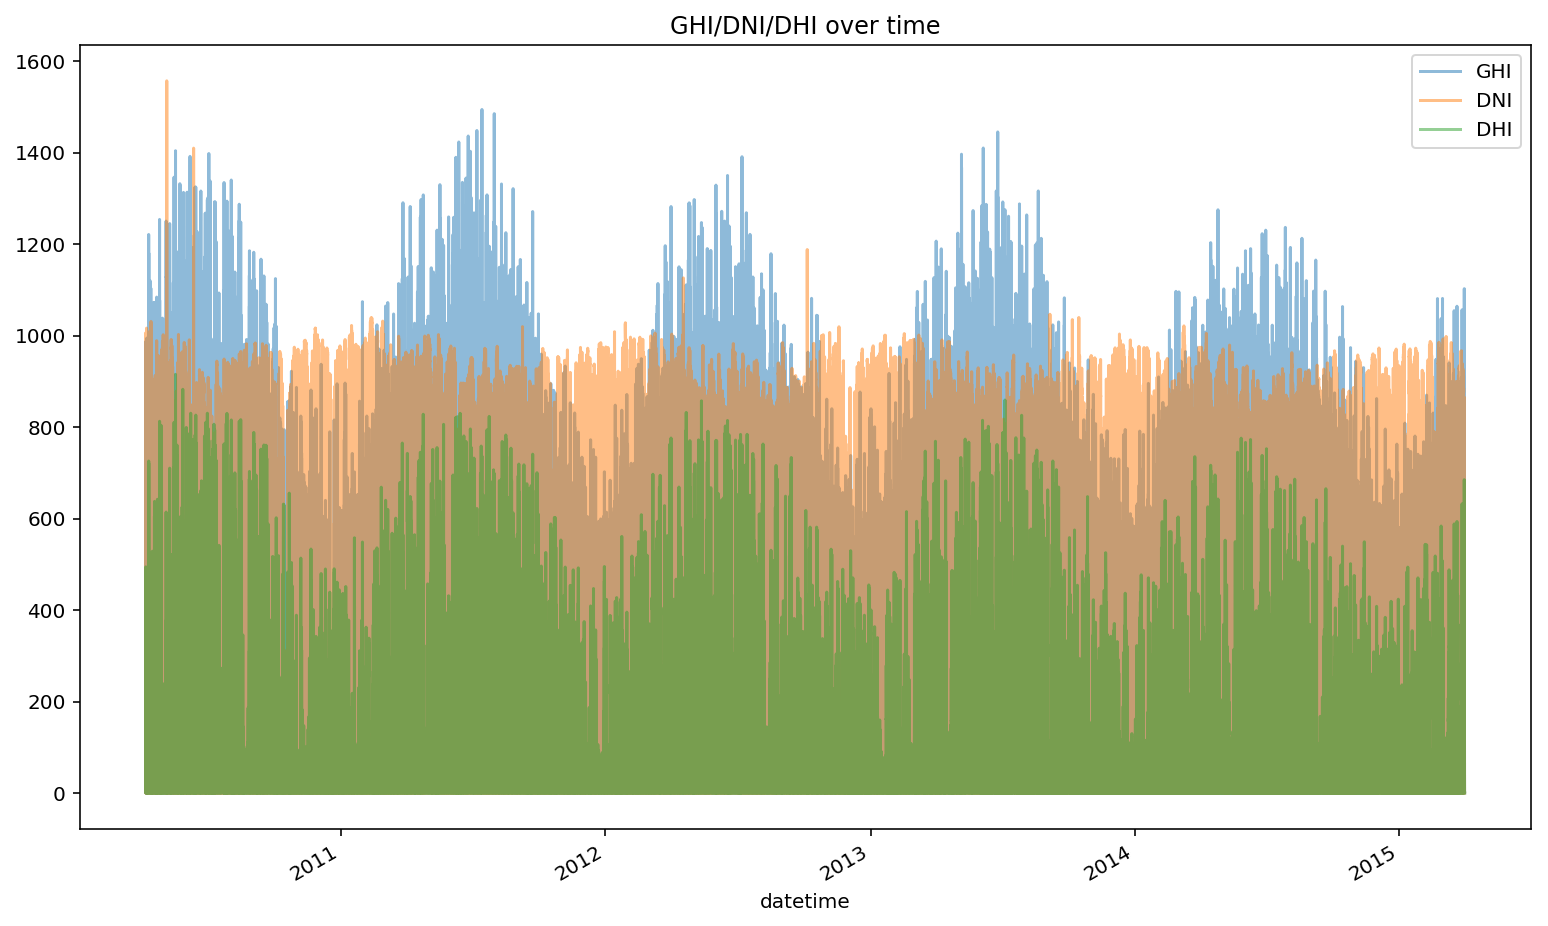

In [13]:
# Irradiance metrics over time
data[['GHI', 'DNI', 'DHI']].plot(alpha=.5)
plt.title('GHI/DNI/DHI over time');

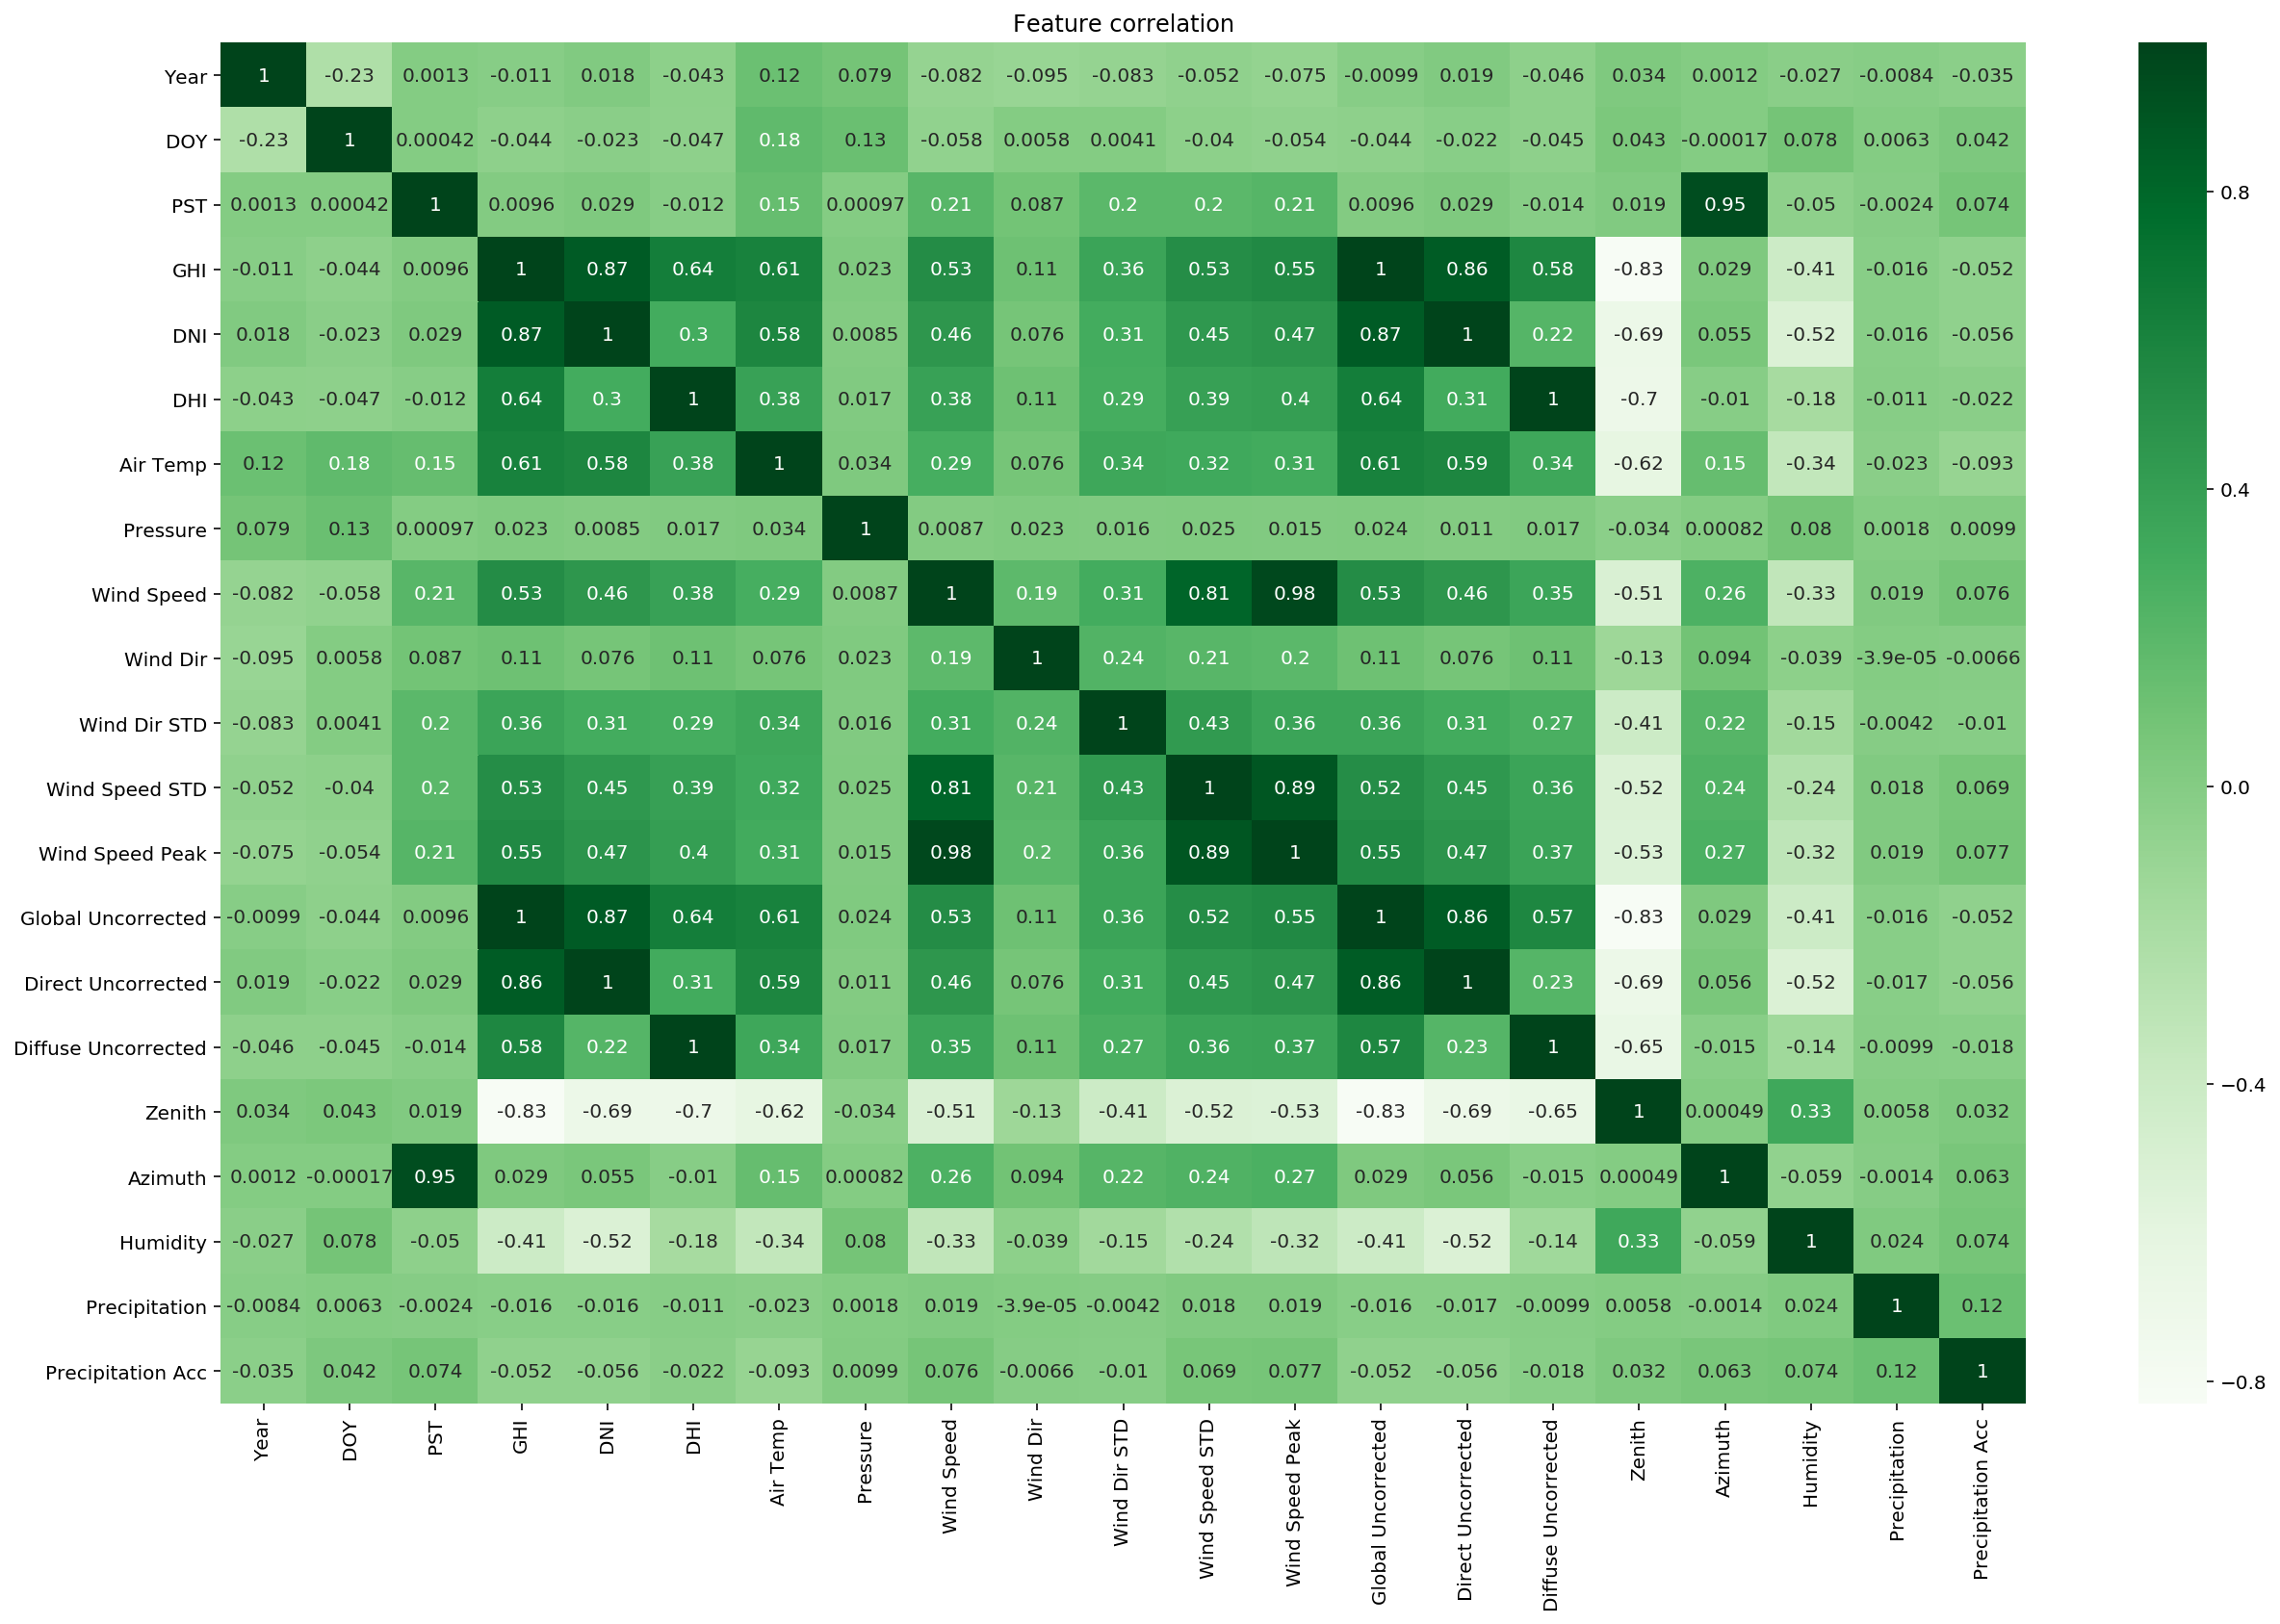

In [14]:
# Feature correlation for all features
plt.figure(figsize=(21, 13))
sns.heatmap(data.corr(), cmap='Greens', annot=True)
plt.title('Feature correlation');

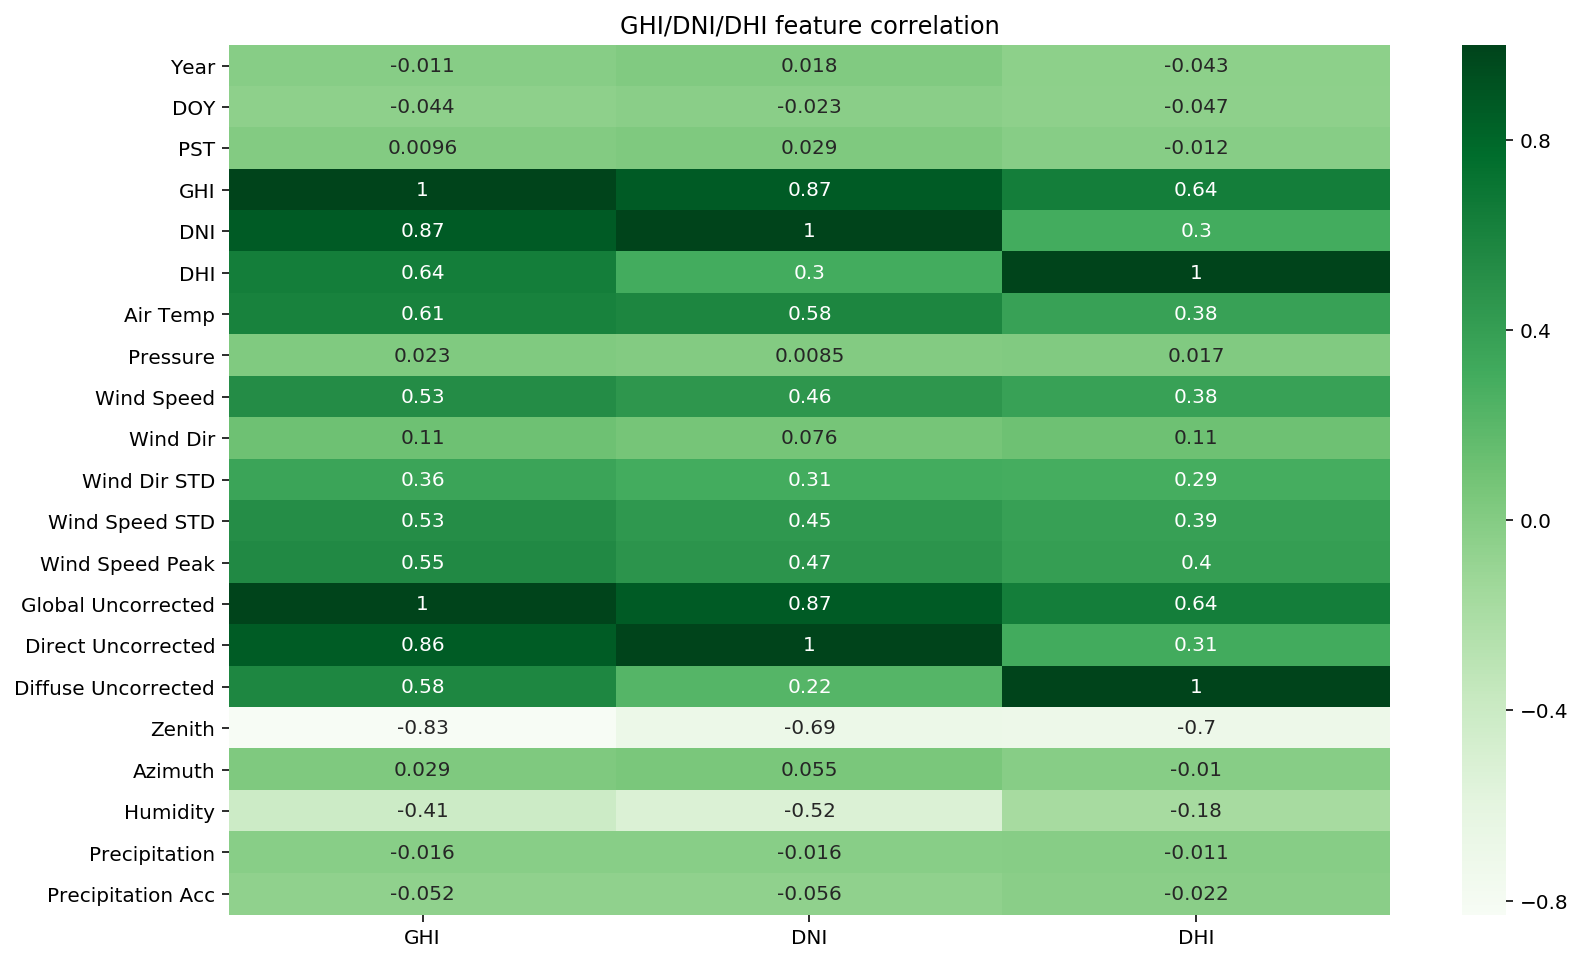

In [15]:
# Feature correlation for irradiance metrics
sns.heatmap(data.corr()[['GHI', 'DNI', 'DHI']], cmap='Greens', annot=True)
plt.title('GHI/DNI/DHI feature correlation');

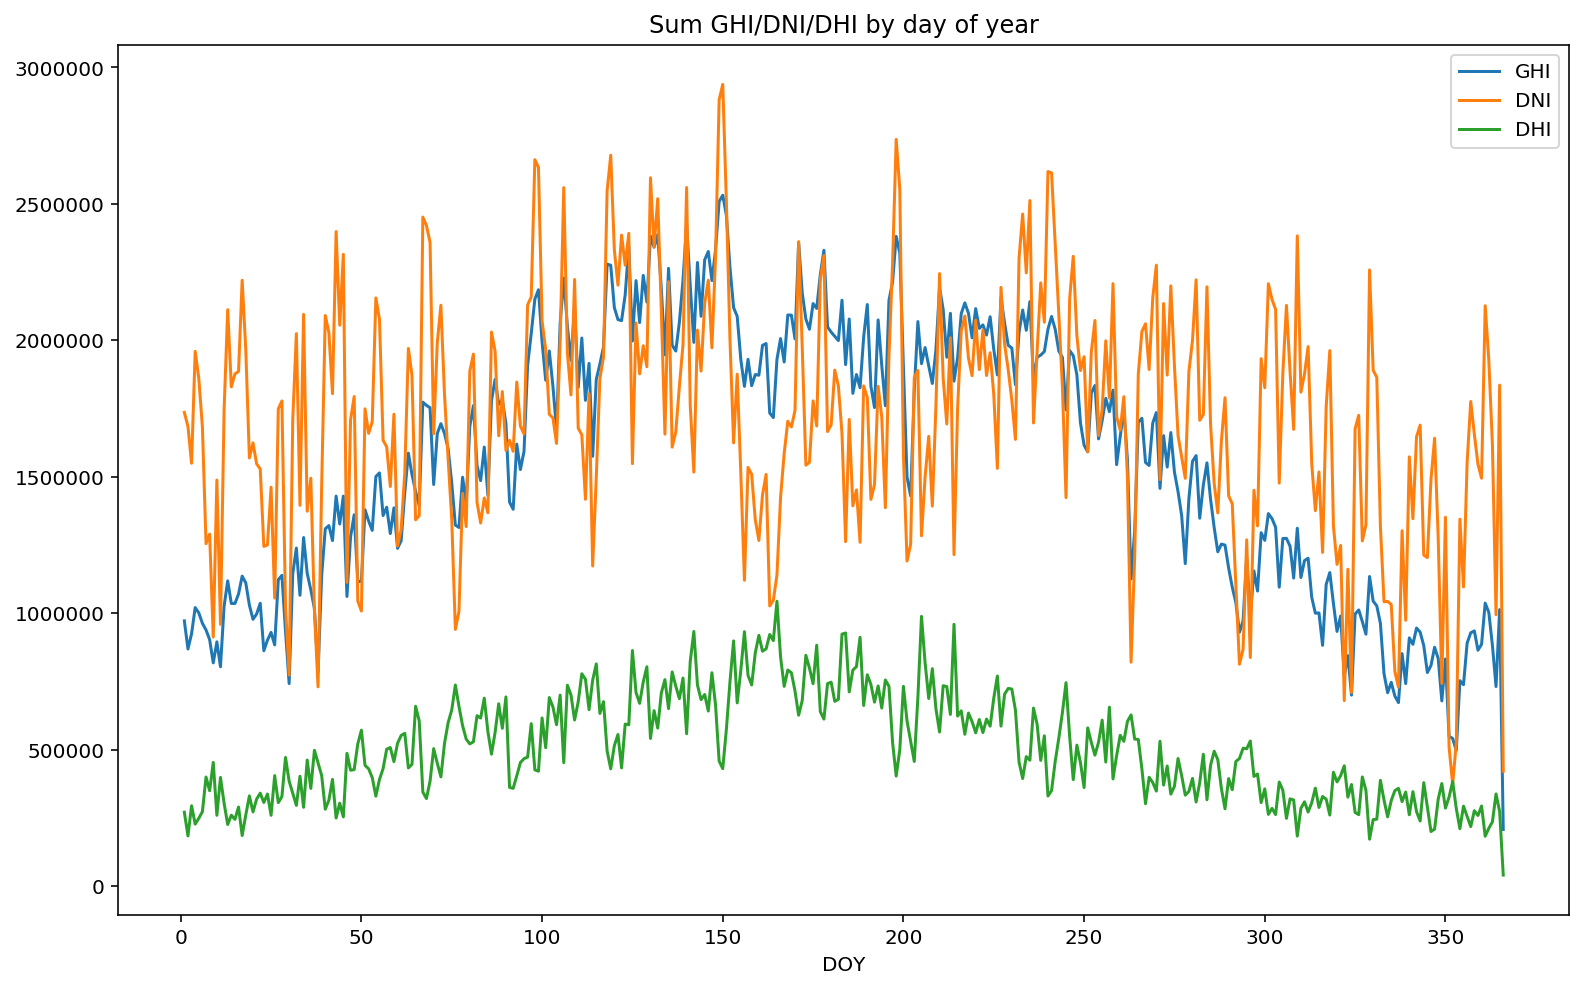

In [16]:
# Average DNI/GHI/DHI over hours.
data.groupby('DOY').sum()[['GHI', 'DNI', 'DHI']].plot()
plt.title('Sum GHI/DNI/DHI by day of year');

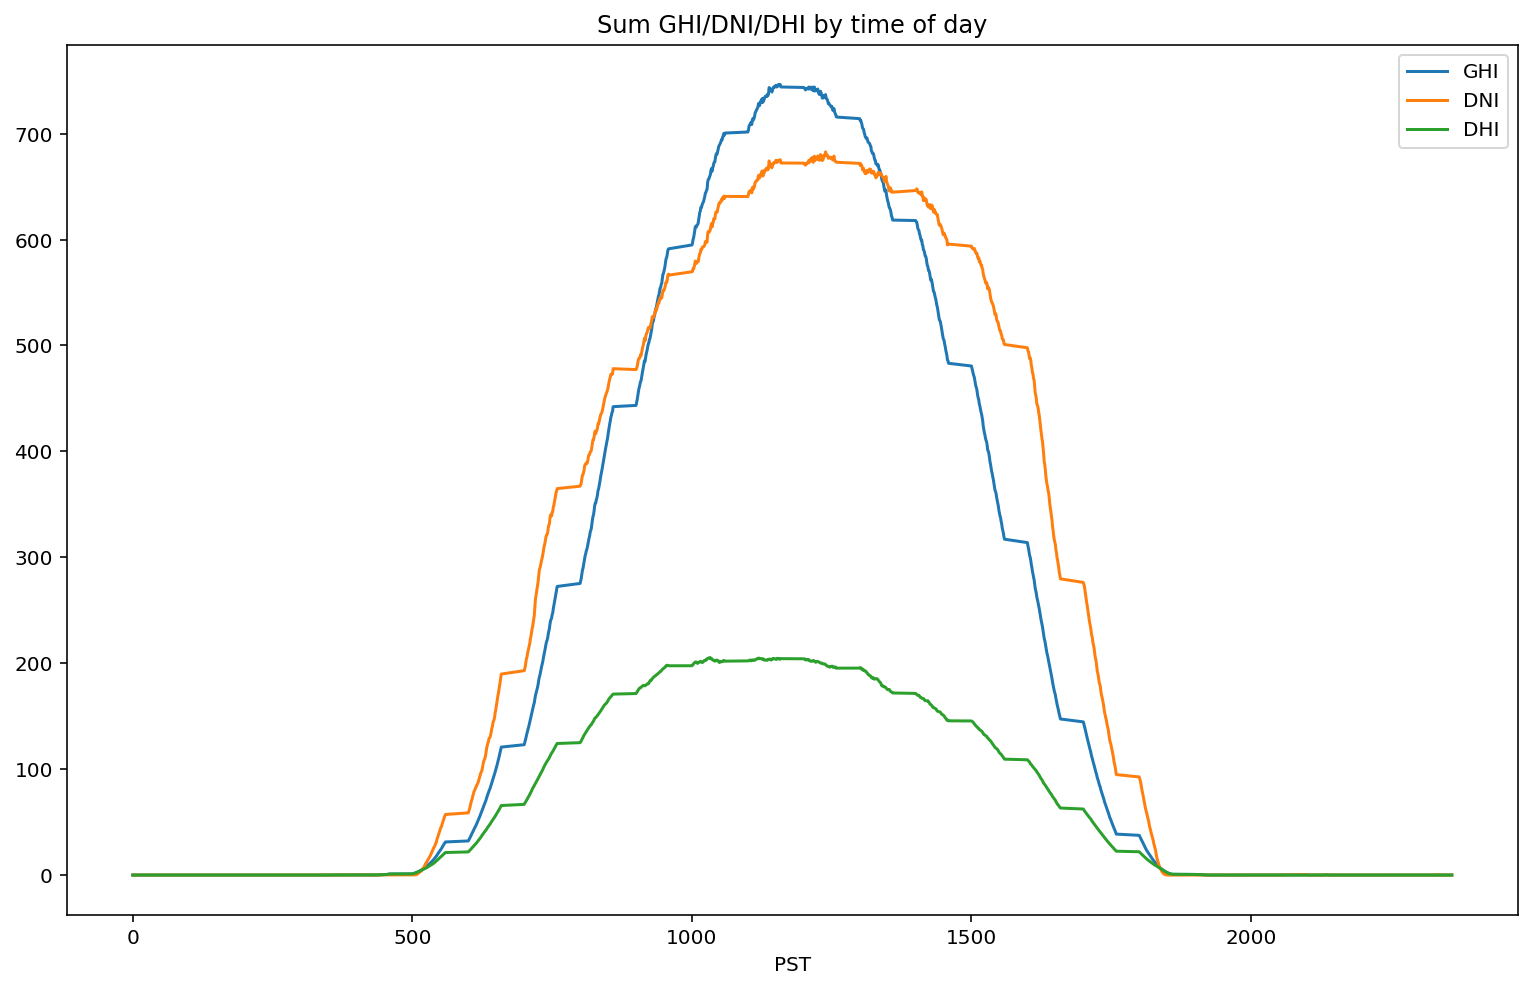

In [17]:
# Average DNI/GHI/DHI over DOY.
data.groupby('PST').mean()[['GHI', 'DNI', 'DHI']].plot()
plt.title('Sum GHI/DNI/DHI by time of day');

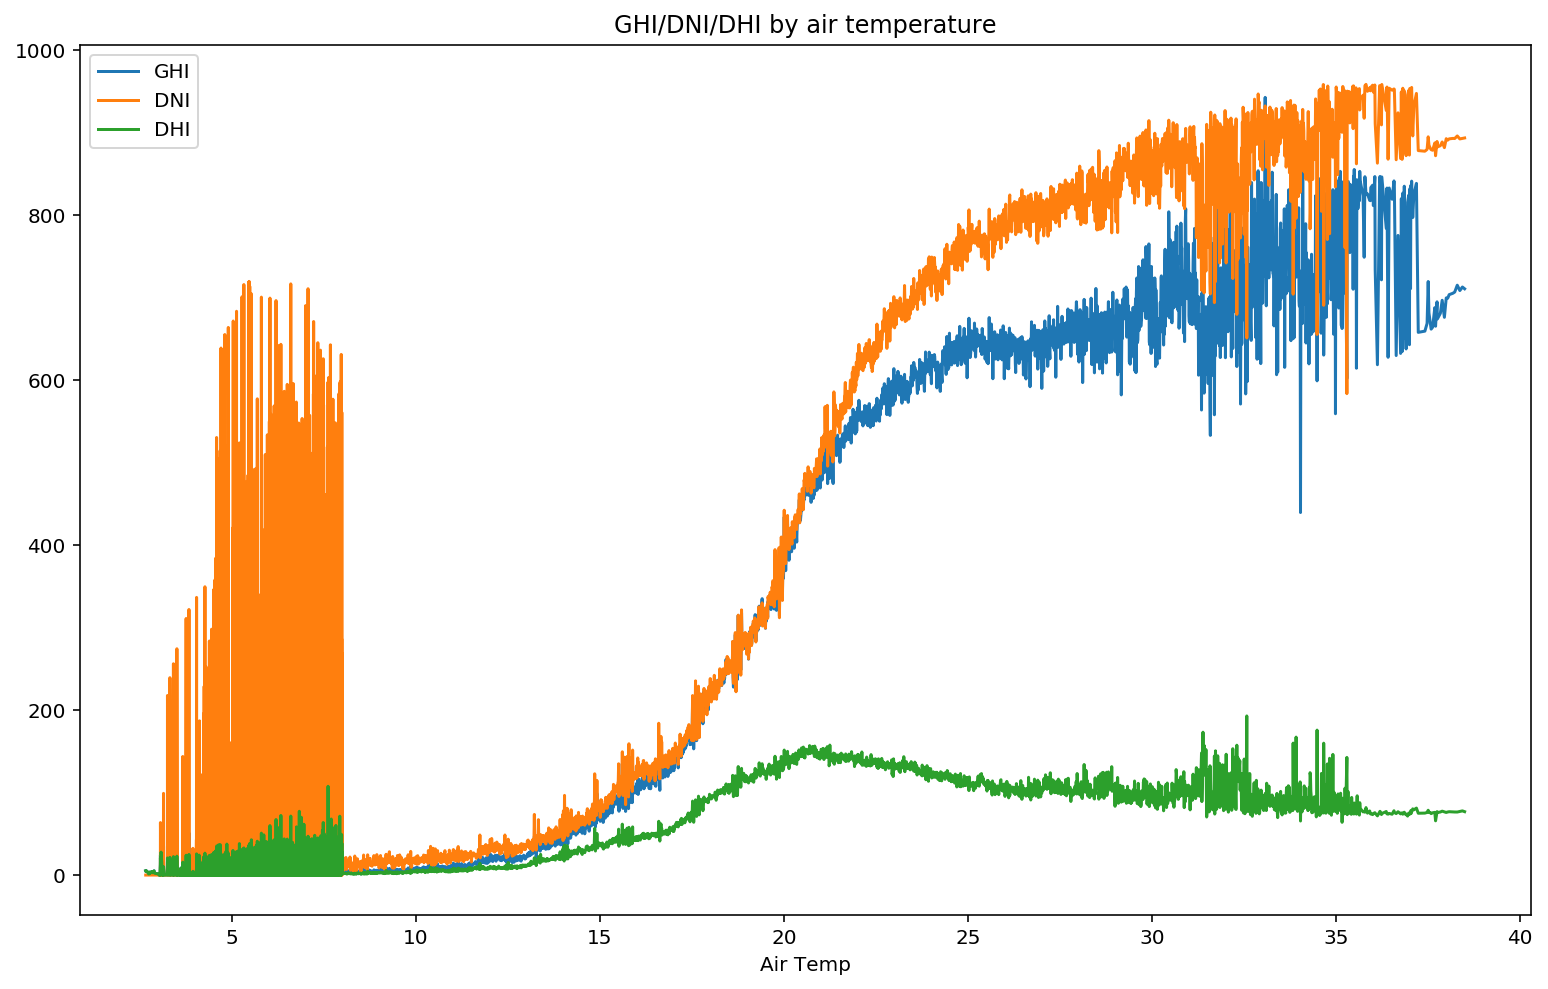

In [18]:
# Irradiance features and air temperature
data.groupby('Air Temp').mean()[['GHI', 'DNI', 'DHI']].plot()
plt.title('GHI/DNI/DHI by air temperature');

# Save to pickle

In [19]:
data.to_pickle('./pickle.pkl')